In [3]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import math
%matplotlib inline

## Cleaning the Train Data

Most of the data cleaning that was required for this didn't seem like the kind of stuff that would be useful for defining custom classes and methods, so we decided to use functions to accomplish the necessary cleaning

In [6]:
train_df = pd.read_csv('https://raw.githubusercontent.com/cl65610/west_nile/master/assets/train.csv')

In [7]:
def to_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

def label_encoding(df, category_list):
    le = LabelEncoder()
    for col in category_list:
        df[col] = le.fit_transform(df[col])
    return df

def date_columns(df):
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day'] = df['month']*30 + df.index.day
    return df

train_df = to_date(train_df)
train_df = date_columns(train_df)
train_df = label_encoding(train_df, ['Species', 'Trap'])

In [10]:
features_to_keep = ['Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 
                   'day', 'month', 'year']
final_train = train_df[features_to_keep]

In [11]:
final_train.head()

,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,day,month,year
Date,,,,,,,,,,
2007-05-29,2,1,41.954690,-87.800991,9,1,0,179,5,2007
2007-05-29,3,1,41.954690,-87.800991,9,1,0,179,5,2007
2007-05-29,3,6,41.994991,-87.769279,9,1,0,179,5,2007
2007-05-29,2,13,41.974089,-87.824812,8,1,0,179,5,2007
2007-05-29,3,13,41.974089,-87.824812,8,4,0,179,5,2007


### Next Steps
Prior to modeling, there are a few more preprocessing steps that we'll need to do. Specifically, we will get dummy variables for our categorical columns, and scaling all of our numeric columns. That will also need to be done for the weather data that will be joined below. More importantly, that scaling could be incorporated into a pipeline.

## Cleaning Weather Data

In [10]:
weather_df = pd.read_csv("https://raw.githubusercontent.com/cl65610/west_nile/master/assets/weather.csv")

In [11]:
weather_df = to_date(weather_df)
weather_df.head(10)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,...,M,0.0,0.00,29.10,29.82,1.7,27,9.2,5,151
2007-05-01,2,84,52,68,M,51,57,0,3,-,...,M,M,0.00,29.18,29.82,2.7,25,9.6,5,151
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,...,M,0.0,0.00,29.38,30.09,13.0,4,13.4,5,152
2007-05-02,2,60,43,52,M,42,47,13,0,-,...,M,M,0.00,29.44,30.08,13.3,2,13.4,5,152
2007-05-03,1,66,46,56,2,40,48,9,0,0446,...,M,0.0,0.00,29.39,30.12,11.7,7,11.9,5,153
2007-05-03,2,67,48,58,M,40,50,7,0,-,...,M,M,0.00,29.46,30.12,12.9,6,13.2,5,153
2007-05-04,1,66,49,58,4,41,50,7,0,0444,...,M,0.0,T,29.31,30.05,10.4,8,10.8,5,154
2007-05-04,2,78,51,M,M,42,50,M,M,-,...,M,M,0.00,29.36,30.04,10.1,7,10.4,5,154
2007-05-05,1,66,53,60,5,38,49,5,0,0443,...,M,0.0,T,29.40,30.10,11.7,7,12.0,5,155


In [12]:
keeper_columns = ['Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'PrecipTotal', 'Sunrise', 'Sunset', 'month', 'day']
for col in keeper_columns:
    weather_df[col] = pd.to_numeric(weather_df[col],errors='coerce')

In [13]:
weather_df.shape

(2944, 23)

In [14]:
avg_weather = weather_df[keeper_columns].resample('D').mean()
final_weather = avg_weather[avg_weather.Tmax.isnull() == False]

In [15]:
final_weather.isnull().sum()

Tmax            0
Tmin            0
Tavg            0
Depart          0
DewPoint        0
PrecipTotal    64
Sunrise         0
Sunset          0
month           0
day             0
dtype: int64

In [16]:
final_weather.fillna(method='bfill', limit=3, inplace=True)
final_weather.isnull().sum()

/Users/TerryONeill/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2756: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
PrecipTotal    0
Sunrise        0
Sunset         0
month          0
day            0
dtype: int64

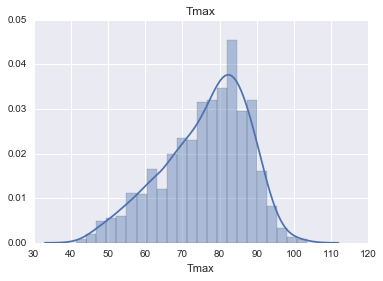

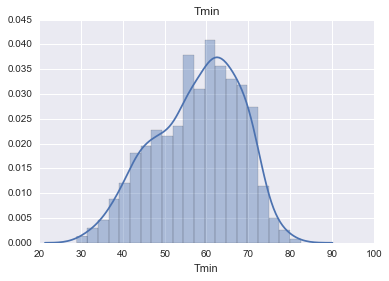

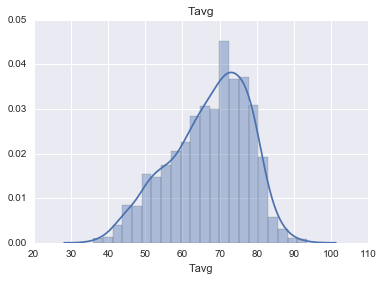

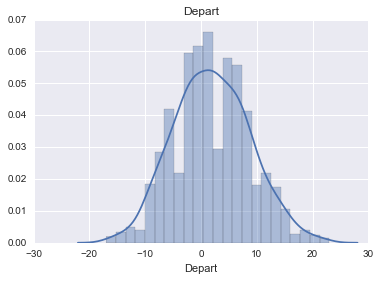

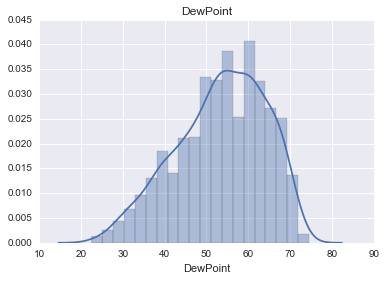

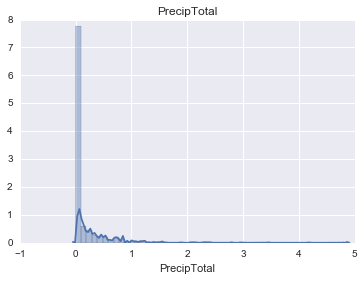

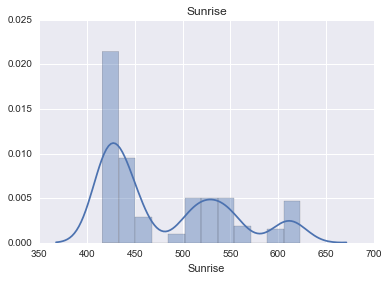

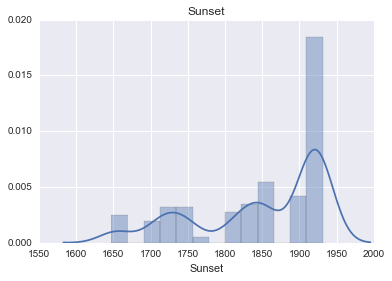

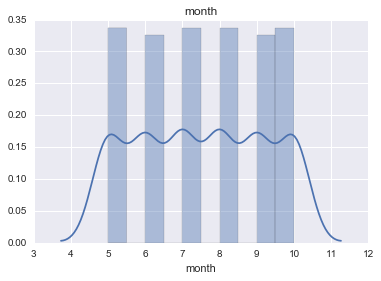

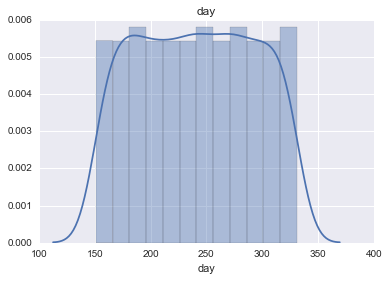

In [19]:
for col in keeper_columns:
    sns.distplot(final_weather[col])
    plt.title(col)
    plt.show()

### Next Steps

Before modeling, we intend to run principal component analysis on this weather data since there are undoubtedly correlations in it, and I feel like we can capture a lot of that in fewer features. That's another thing that we could incorporate into a pipeline. Above, I've plotted the contents of these variables to show that they are normally distributed. The only on that we'll likely be unable to include is total precipitation, which has a remarkably large peak. Sunrise and Sunset also don't follow normal distributions, so they'll likely be excluded. 

## Joining the two dataframes

In [25]:
print final_train.shape
print final_weather.shape

(10506, 10)
(1472, 10)


In [40]:
## have to make a suffix to add to weather columns day and month since they have the 
## same name as columns in the final train dataframe
df = final_train.join(final_weather, rsuffix = '_weather')

In [41]:
print df.shape
df.head()

(10506, 20)


,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,day,month,year,Tmax,Tmin,Tavg,Depart,DewPoint,PrecipTotal,Sunrise,Sunset,month_weather,day_weather
Date,,,,,,,,,,,,,,,,,,,,
2007-05-29,2,1,41.954690,-87.800991,9,1,0,179,5,2007,88.0,62.5,75.5,10.0,58.5,0.0,421.0,1917.0,5.0,179.0
2007-05-29,3,1,41.954690,-87.800991,9,1,0,179,5,2007,88.0,62.5,75.5,10.0,58.5,0.0,421.0,1917.0,5.0,179.0
2007-05-29,3,6,41.994991,-87.769279,9,1,0,179,5,2007,88.0,62.5,75.5,10.0,58.5,0.0,421.0,1917.0,5.0,179.0
2007-05-29,2,13,41.974089,-87.824812,8,1,0,179,5,2007,88.0,62.5,75.5,10.0,58.5,0.0,421.0,1917.0,5.0,179.0
2007-05-29,3,13,41.974089,-87.824812,8,4,0,179,5,2007,88.0,62.5,75.5,10.0,58.5,0.0,421.0,1917.0,5.0,179.0


In [42]:
df.to_csv('/Users/TerryONeill/west_nile/west_nile/assets/train_weather_join.csv')

### Summary

The join was successful. Weather data was successfully placed onto each sample location. We decided to use the average weather data instead of choosing one or the other or trying to map a trap location to its nearest weather station. The variance between the two appeared to be minimal. 

At this point, there is some preprocessing that still needs to happen before we can begin modeling. As stated above, all of the data needs to be scaled, and the categorical data will need dummy variables created. Further, there's some feature engineering that we'd like to do, specifically using PCA on the weather data. There is also a major piece of feature engineering that we will try to work through. In an effort to utilize the spray data, we will fit a dbscan model on the sampling latitudes and longitudes, thereby defining different "spray zones." We will save this model fit and use it to predict which "spray zone" a trap would fall in. This would allow us to join the spray data that we possess on date. 

In addition to the above described feature engineering, our next step is model selection. Given the geo-spatial nature of our data, KMeansClassifier is an obvious choice for modeling. Similarly, we will also consider a radial-based SVM classifier. We're intrigued to learn how time series modeling may be effective for this problem. 

# Test Data Cleaning

In [21]:
test_df = pd.read_csv('https://raw.githubusercontent.com/cl65610/west_nile/master/assets/test.csv')
print test_df.shape
test_df.head()

(116293, 11)


,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [8]:
test_df = to_date(test_df)
test_df = date_columns(test_df)
test_df = label_encoding(test_df, ['Species', 'Trap'])


In [9]:
features_to_keep = ['Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy', 
                   'day', 'month', 'year']
final_test = test_df[features_to_keep]
final_test.head()

,Species,Trap,Latitude,Longitude,AddressAccuracy,day,month,year
Date,,,,,,,,
2008-06-11,2,1,41.95469,-87.800991,9,191,6,2008
2008-06-11,3,1,41.95469,-87.800991,9,191,6,2008
2008-06-11,1,1,41.95469,-87.800991,9,191,6,2008
2008-06-11,4,1,41.95469,-87.800991,9,191,6,2008
2008-06-11,6,1,41.95469,-87.800991,9,191,6,2008


In [22]:
print final_test.shape
print final_weather.shape

(116293, 8)
(1472, 10)


In [23]:
## have to make a suffix to add to weather columns day and month since they have the 
## same name as columns in the final train dataframe
final_df = final_test.join(final_weather, rsuffix = '_weather')

In [24]:
print df.shape
final_df.head()

(116293, 18)


,Species,Trap,Latitude,Longitude,AddressAccuracy,day,month,year,Tmax,Tmin,Tavg,Depart,DewPoint,PrecipTotal,Sunrise,Sunset,month_weather,day_weather
Date,,,,,,,,,,,,,,,,,,
2008-06-11,2,1,41.95469,-87.800991,9,191,6,2008,86.0,63.5,75.0,7.0,55.5,0.0,416.0,1926.0,6.0,191.0
2008-06-11,3,1,41.95469,-87.800991,9,191,6,2008,86.0,63.5,75.0,7.0,55.5,0.0,416.0,1926.0,6.0,191.0
2008-06-11,1,1,41.95469,-87.800991,9,191,6,2008,86.0,63.5,75.0,7.0,55.5,0.0,416.0,1926.0,6.0,191.0
2008-06-11,4,1,41.95469,-87.800991,9,191,6,2008,86.0,63.5,75.0,7.0,55.5,0.0,416.0,1926.0,6.0,191.0
2008-06-11,6,1,41.95469,-87.800991,9,191,6,2008,86.0,63.5,75.0,7.0,55.5,0.0,416.0,1926.0,6.0,191.0


In [25]:
final_df.to_csv('/Users/TerryONeill/west_nile/west_nile/assets/final_df.csv')